In [1]:
%config IPCompleter.greedy=True
import findspark
findspark.init("C:\spark")
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import collections
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import re
import math
import time

conf=SparkConf().setAppName("BookRecommender")
sc = SparkContext.getOrCreate(conf=conf) 
sc.setCheckpointDir("Project/CheckPointDir")

In [2]:
import socket
import platform
hostname = socket.gethostname()
ip = socket.gethostbyname(hostname)
uname = platform.uname()
print(f"Hostname: {hostname}")
print(f"Ip address: {ip}")
print(f"System: {uname.system}")
print(f"Release: {uname.release}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")
print(f"Processor: {uname.processor}")

Hostname: LAPTOP-UEQCSDT9
Ip address: 192.168.0.20
System: Windows
Release: 10
Version: 10.0.22621
Machine: AMD64
Processor: Intel64 Family 6 Model 142 Stepping 12, GenuineIntel


In [3]:
dfUser = sc.textFile("C:/Users/USER/Desktop/dataset/Users.csv")
dfBooks = sc.textFile("C:/Users/USER/Desktop/dataset/Books.csv")
dfRatings = sc.textFile("C:/Users/USER/Desktop/dataset/Book-Ratings.csv")

Split DF's for each fields

In [4]:
users_fields = dfUser.map(lambda lines: lines.replace('"','').split(";"))
books_fields = dfBooks.map(lambda lines: lines.replace('"','').split(";"))
rating_fields = dfRatings.map(lambda lines: lines.replace('"','').split(";"))

In [5]:
def handle_isbn(lst2):
    lst = lst2.collect()
    arr=[]
    arr2=[]
    for i in lst:
        arr.append(re.sub("[^0-9]",'1',i))
    for i in arr:
        if len(i)>=9:
            arr2.append(int(i[len(i)-9:]))
    return sc.parallelize(arr2)

def handle_isbn_str(line):
    line1 = re.sub("[^0-9]",'1',line)
    if len(line1)>=9:
        line2 = int(line1[len(line1)-9:])
        return int(line2)
    else:
        return int(line1)

Data Correction for Bad Data in Ages

In [6]:
def handle_age(age):
    try:
        return int(age)
    except:
        return int(300)

USERS Fields & BOOKS Fields & BOOK Rating Fields

In [7]:
users_id = users_fields.map(lambda field: field[0])
users_location = users_fields.map(lambda field: field[1])
users_age = users_fields.map(lambda field: field[2])

books_isbn = handle_isbn(books_fields.map(lambda field: field[0]))
books_name = books_fields.map(lambda field: field[1])
books_writer = books_fields.map(lambda field: field[2])
books_press = books_fields.map(lambda field: field[3])

rating_users_id = rating_fields.map(lambda field: float(field[0]))
rating_books_isbn = handle_isbn(rating_fields.map(lambda field: field[1]))
rating_books_rating = rating_fields.map(lambda field: float(field[2]))

In [8]:
age_list = users_age.map(lambda item: handle_age(item))
age_list_filtered = age_list.filter(lambda item: item <= 90 and item >=0 )
age_counts = collections.OrderedDict(sorted(age_list_filtered.countByValue().items()))
age_list_filtered.stats()

(count: 167666, mean: 34.54562045972393, stdev: 13.769988967606224, max: 90.0, min: 0.0)

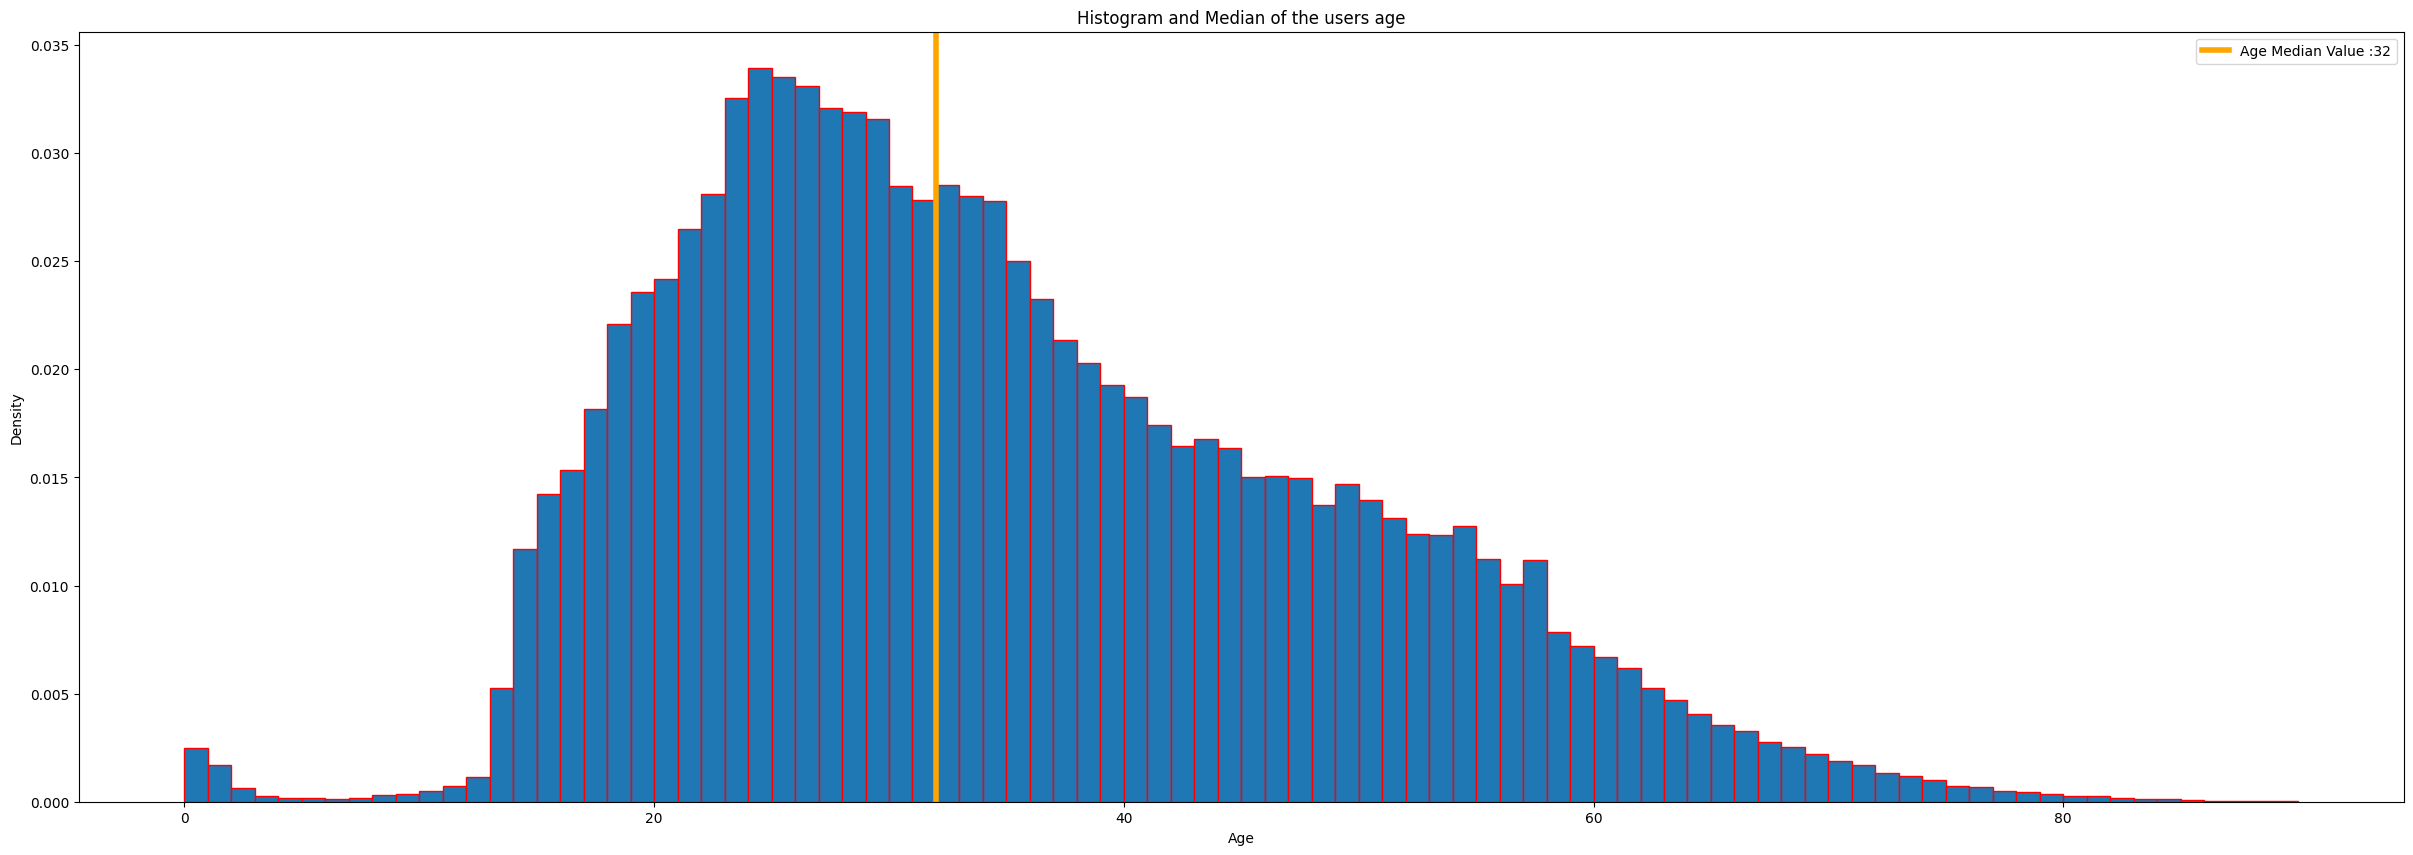

In [9]:
age_values = list(age_counts.values())
age_bins = list(age_counts.keys())
plt.hist(age_list_filtered.collect(),bins=age_bins,density=True, edgecolor='red')
plt.axvline(int(np.median(age_list_filtered.collect())),color='orange',label=f'Age Median Value :{int(np.median(age_list_filtered.collect()))}',linewidth=4)
plt.legend()
plt.title('Histogram and Median of the users age')
plt.ylabel('Density')
plt.xlabel('Age')
fig=plt.gcf()
fig.set_size_inches(30,10)


USERS' Countries Location & TOP 10 Countries That The Most Users Data Collected

In [10]:
location_fields = users_location.map(lambda x: x.replace('""','').split(','))
location_country = location_fields.map(lambda x: x[-1])

countryCounts = location_country.map(lambda word: (word,1)).reduceByKey(lambda a,b: a + b)
orderedCountryCounts=countryCounts.sortBy(lambda x : x[1],ascending=False)
print(f'TOP 10 Countries That The Most Data Collected: ')
orderedCountryCounts.take(10)

TOP 10 Countries That The Most Data Collected: 


[(' usa', 76495),
 (' spain', 12691),
 (' united kingdom', 12541),
 (' canada', 11385),
 (' germany', 10642),
 (' australia', 8896),
 (' italy', 5377),
 (' france', 3037),
 (' portugal', 2721),
 (' new zealand', 2026)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


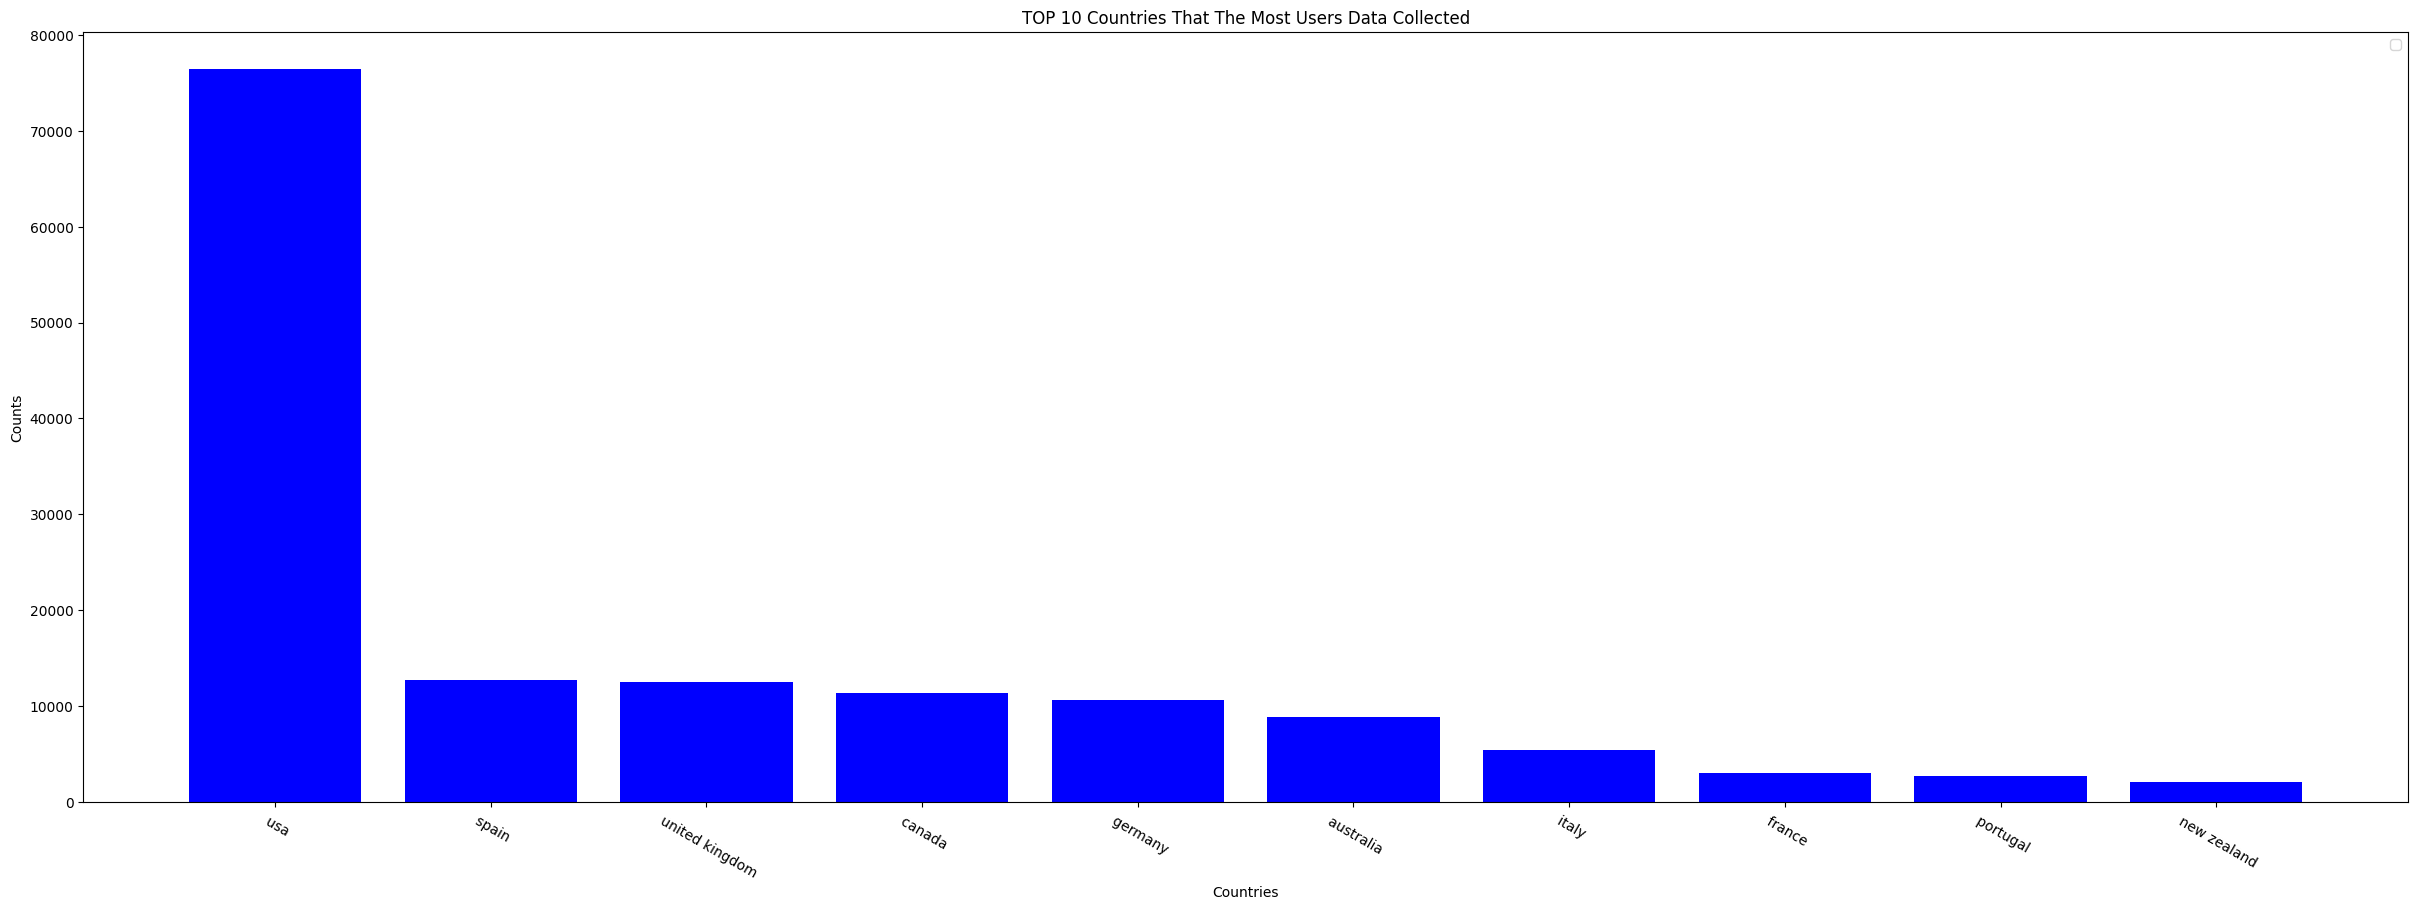

In [11]:
x = orderedCountryCounts.keys().take(10)
y = orderedCountryCounts.values().take(10)
plt.bar(x, y, color = 'blue',)
plt.xticks(rotation = -30)
plt.legend()
plt.title('TOP 10 Countries That The Most Users Data Collected')
plt.xlabel('Countries')
plt.ylabel('Counts')
fig = plt.gcf()
fig.set_size_inches(30,10)

In [12]:
rating_books_rating.stats()

(count: 397245, mean: 7.601852760890583, stdev: 1.8412729800421157, max: 10.0, min: 1.0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


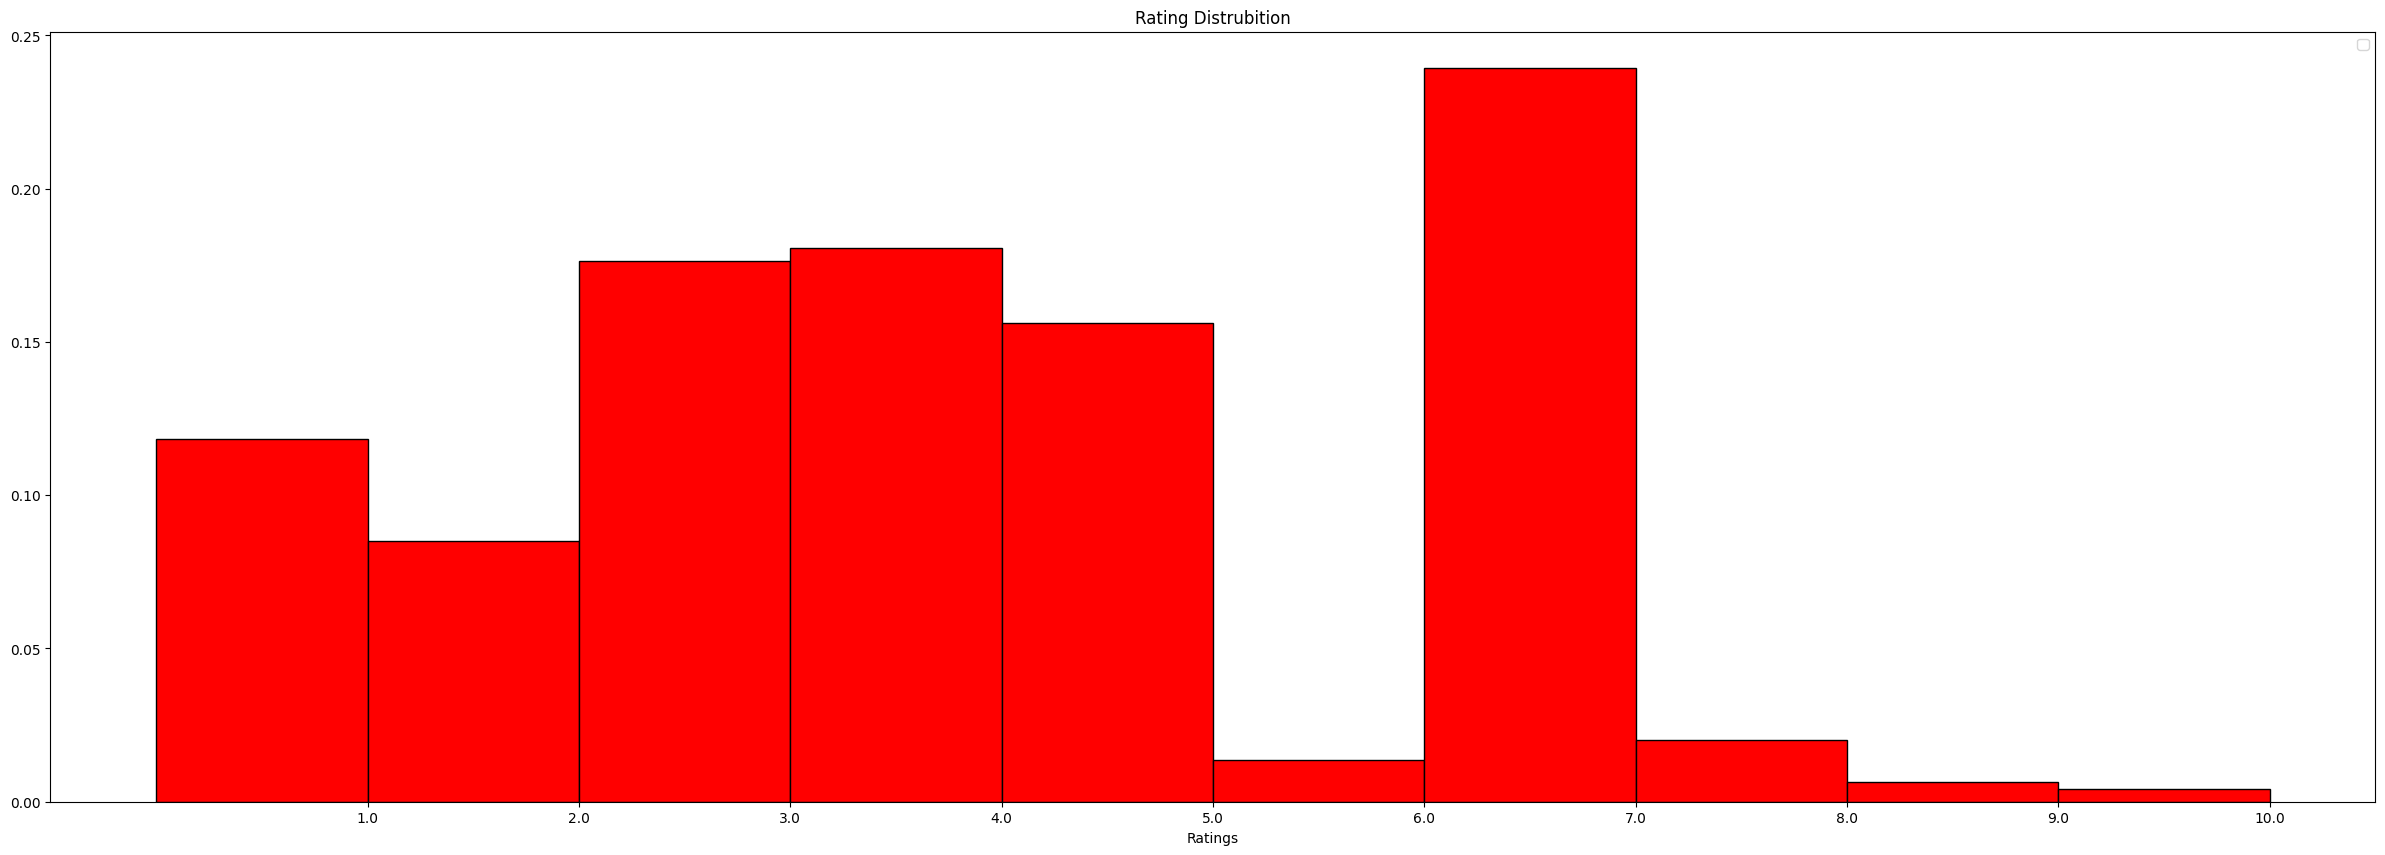

In [13]:
count_by_rating = rating_books_rating.countByValue()
x_axis = np.array(sorted(count_by_rating.keys()))
y_axis = np.array([float(c) for c in count_by_rating.values()])
y_axis_normed = y_axis / y_axis.sum()
pos = np.arange(len(x_axis))
width = 1.0
ax  = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis_normed, width, color = 'red', edgecolor='black')
plt.legend()
plt.title('Rating Distrubition')
plt.xlabel('Ratings')
fig = plt.gcf()
fig.set_size_inches(30,10)

First 5 raw ratings

In [14]:
raw_ratings = rating_fields.map(lambda x : x)
raw_ratings.take(5)

[['8', '2005018', '5'],
 ['8', '074322678X', '5'],
 ['8', '887841740', '5'],
 ['8', '1552041778', '5'],
 ['8', '1567407781', '6']]

In [15]:
from pyspark.mllib.recommendation import ALS
from pyspark.mllib.recommendation import Rating

ratings = raw_ratings.map(lambda x : Rating(int(x[0]), handle_isbn_str(x[1]), int(x[2])))
print("Ratings:", ratings.take(10))

train, test = ratings.randomSplit([0.7, 0.3])
testData = test.map(lambda l : (int(l[0]), int(l[1])))

Ratings: [Rating(user=8, product=2005018, rating=5.0), Rating(user=8, product=743226781, rating=5.0), Rating(user=8, product=887841740, rating=5.0), Rating(user=8, product=552041778, rating=5.0), Rating(user=8, product=567407781, rating=6.0), Rating(user=8, product=575663937, rating=6.0), Rating(user=8, product=881320189, rating=7.0), Rating(user=9, product=452264464, rating=6.0), Rating(user=10, product=477024456, rating=6.0), Rating(user=12, product=879384493, rating=10.0)]


In [17]:
start = time.time()
model10_10_01 = ALS.train(train, 10,iterations=10,seed=5024,lambda_ = 0.01)
end1 = time.time() - start
print("Runtime for 10_10_01: ", end1)

start = time.time()
model10_50_01 = ALS.train(train, 10,iterations=50,seed=5024,lambda_ = 0.01)
end2 = time.time() - start
print("Runtime for: 10_50_01: ", end2)

start = time.time()
model10_200_01 = ALS.train(train, 10,iterations=200,seed=5024,lambda_ = 0.01)
end3 = time.time() - start
print("Runtime for: 10_200_01: ", end3)

start = time.time()
model10_10_1 = ALS.train(train, 10,iterations=10,seed=5024,lambda_ = 0.1)
end4 = time.time() - start
print("Runtime for: 10_10_1: ", end4)

start = time.time()
model10_50_1 = ALS.train(train, 10,iterations=50,seed=5024,lambda_ = 0.1)
end5 = time.time() - start
print("Runtime for: 10_50_1: ", end5)

start = time.time()
model10_200_1 = ALS.train(train, 10,iterations=200,seed=5024,lambda_ = 0.1)
end6 = time.time() - start
print("Runtime for: 10_200_1: ", end6)

Runtime for 10_10_01:  21.394713401794434
Runtime for: 10_50_01:  73.0247175693512
Runtime for: 10_200_01:  232.90071511268616
Runtime for: 10_10_1:  21.48739504814148
Runtime for: 10_50_1:  74.47223019599915
Runtime for: 10_200_1:  248.84292817115784


In [18]:
start = time.time()
model50_10_01 = ALS.train(train, 50,iterations=10,seed=5024,lambda_ = 0.01)
end7 = time.time() - start
print("Runtime for: 50_10_01: ", end7)

start = time.time()
model50_50_01 = ALS.train(train, 50,iterations=50,seed=5024,lambda_ = 0.01)
end8 = time.time() - start
print("Runtime for: 50_50_01: ", end8)

start = time.time()
model50_200_01= ALS.train(train, 50,iterations=200,seed=5024,lambda_ = 0.01)
end9 = time.time() - start
print("Runtime for: 50_200_01: ", end9)

start = time.time()
model50_10_1 = ALS.train(train, 50,iterations=10,seed=5024,lambda_ = 0.1)
end10 = time.time() - start
print("Runtime for: 50_10_1: ", end10)

start = time.time()
model50_50_1 = ALS.train(train, 50,iterations=50,seed=5024,lambda_ = 0.1)
end11 = time.time() - start
print("Runtime for: 50_50_1: ", end11)

start = time.time()
model50_200_1 = ALS.train(train, 50,iterations=200,seed=5024,lambda_ = 0.1)
end12 = time.time() - start
print("Runtime for: 50_200_1: ", end12)

Runtime for: 50_10_01:  77.29432082176208
Runtime for: 50_50_01:  338.787428855896
Runtime for: 50_200_01:  1269.3852922916412
Runtime for: 50_10_1:  89.92562294006348
Runtime for: 50_50_1:  367.19390416145325
Runtime for: 50_200_1:  1411.8820223808289


In [19]:
start = time.time()
model200_10_01 = ALS.train(train, 200,iterations=10,seed=5024,lambda_ = 0.01)
end13 = time.time() - start
print("Runtime for: 200_10_01: ", end13)

start = time.time()
model200_10_1 = ALS.train(train, 200,iterations=10,seed=5024,lambda_ = 0.1)
end14 = time.time() - start
print("Runtime for: 200_10_1: ", end14)

Runtime for: 200_10_01:  1005.0705876350403
Runtime for: 200_10_1:  1012.2237100601196


In [20]:
start = time.time()
model200_50_01 = ALS.train(train, 200,iterations=50,seed=5024,lambda_ = 0.01)
end15 = time.time() - start
print("Runtime for: 200_50_01: ", end15)

start = time.time()
model200_50_1 = ALS.train(train, 200,iterations=50,seed=5024,lambda_ = 0.1)
end16 = time.time() - start
print("Runtime for: 200_50_1: ", end16)

Runtime for: 200_50_01:  4612.79013466835
Runtime for: 200_50_1:  4553.945108890533


In [23]:
start = time.time()
model200_200_01 = ALS.train(train, 200,iterations=200,seed=5024,lambda_ = 0.01)
end17 = time.time() - start
print("Runtime for: 200_200_01: ", end17)

start = time.time()
model200_200_1 = ALS.train(train, 200,iterations=200,seed=5024,lambda_ = 0.1)
end18 = time.time() - start
print("Runtime for: 200_200_1: ", end18)

Runtime for: 200_200_01:  17631.25554537773
Runtime for: 200_200_1:  17658.919082164764


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


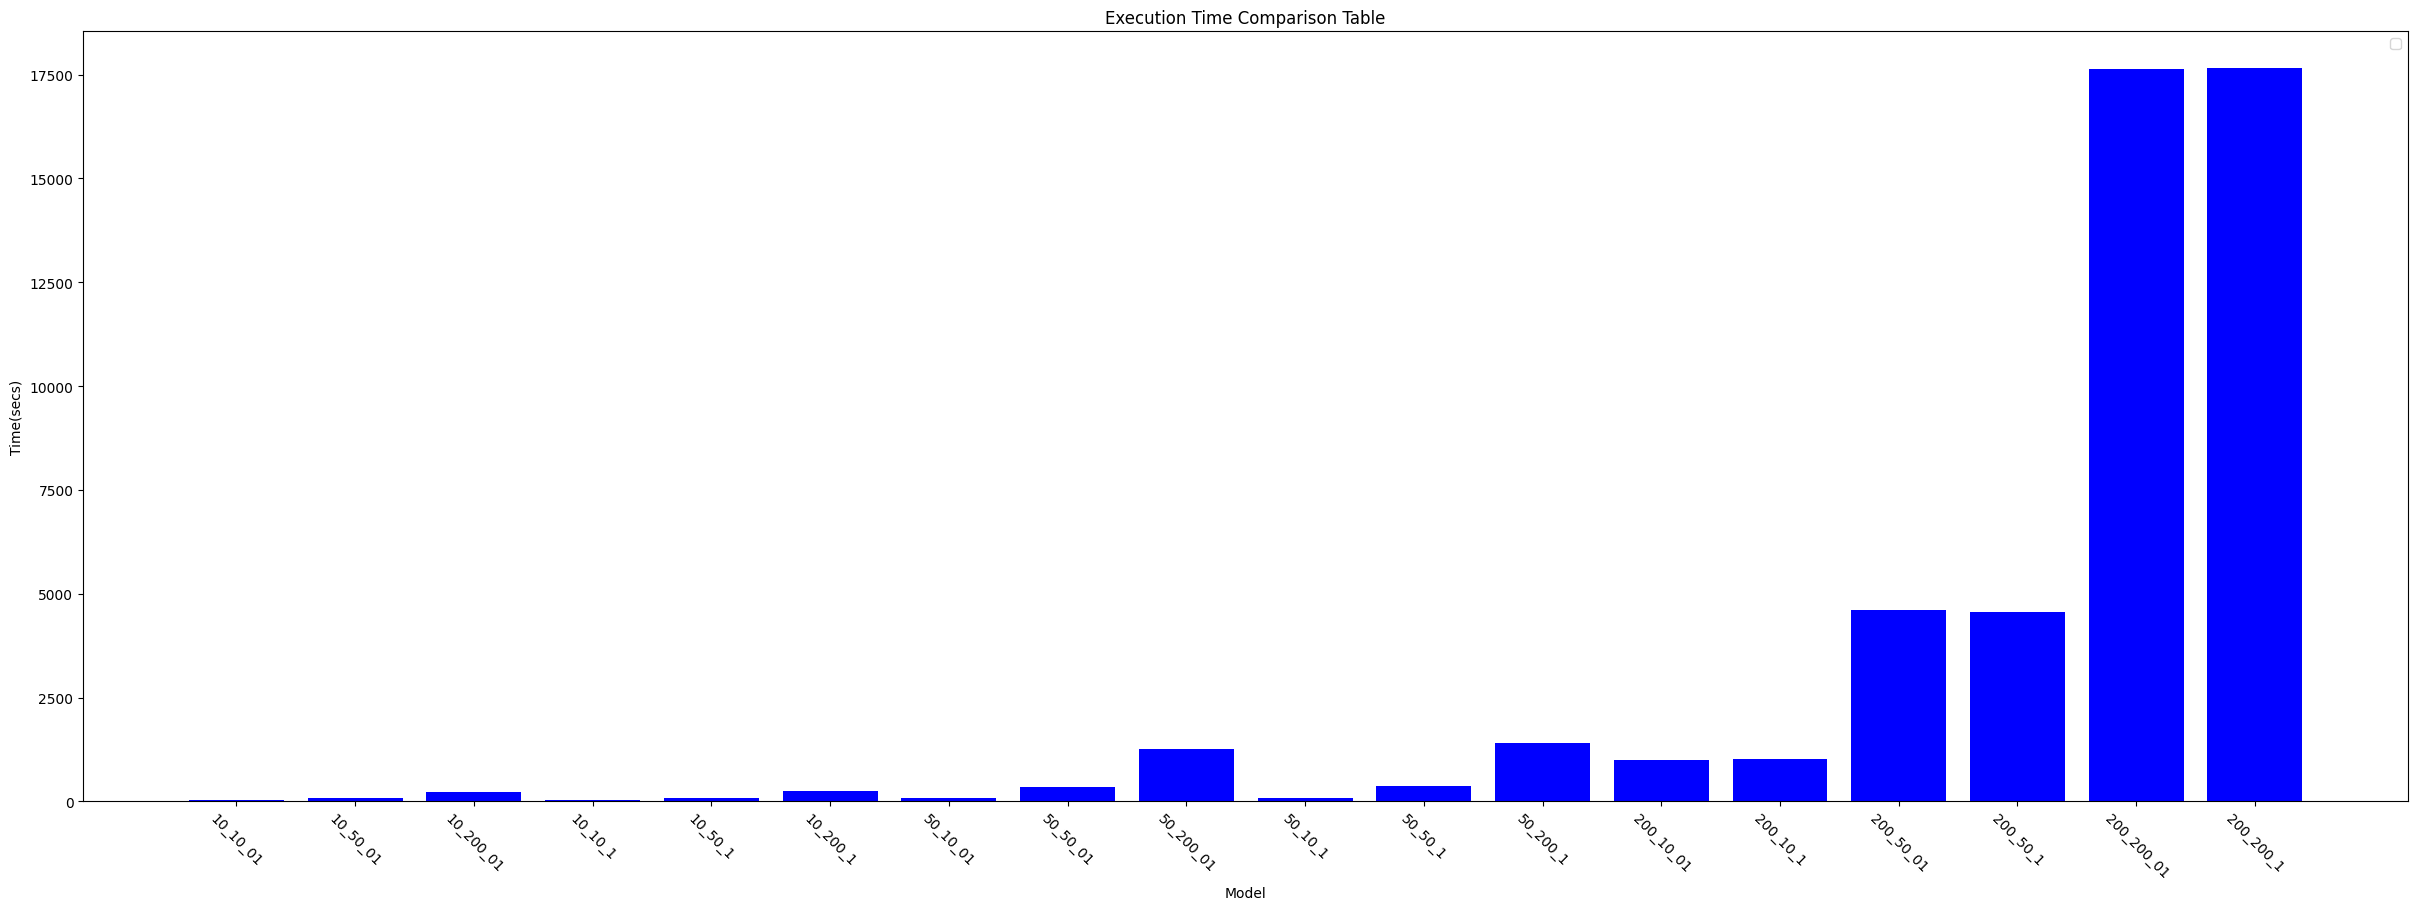

In [24]:
arr = ['10_10_01', '10_50_01', '10_200_01', '10_10_1', '10_50_1', '10_200_1', '50_10_01', '50_50_01', '50_200_01', '50_10_1', '50_50_1', '50_200_1', '200_10_01', '200_10_1', '200_50_01', '200_50_1','200_200_01', '200_200_1']
arr2 = [end1, end2, end3, end4, end5, end6, end7, end8, end9, end10, end11, end12, end13, end14, end15, end16, end17, end18]
plt.bar(arr, arr2, color = 'blue')
plt.xticks(rotation = -45)
plt.legend()
plt.title('Execution Time Comparison Table')
plt.xlabel('Model')
plt.ylabel('Time(secs)')
fig = plt.gcf()
fig.set_size_inches(30,10)

In [25]:
print('\tFirst Model\'s First 10 Users and Their Item Scores: ')
model10_10_01.userFeatures().take(10)

	First Model's First 10 Users and Their Item Scores: 


[(8,
  array('d', [0.026344850659370422, -0.3383219242095947, 0.19760029017925262, -0.19562707841396332, 0.5902324318885803, 0.45014750957489014, -0.1403735727071762, -0.11160893738269806, 0.07938263565301895, -0.6416299939155579])),
 (16,
  array('d', [0.22033940255641937, 0.616655170917511, 0.34502992033958435, 0.18203769624233246, -0.19957910478115082, -0.10767576843500137, 0.12555482983589172, 0.15035870671272278, 0.10345548391342163, -0.34275826811790466])),
 (56,
  array('d', [0.3393677771091461, -0.11022735387086868, 0.054302189499139786, 0.20504717528820038, 0.3235597312450409, -0.31304609775543213, -0.16412103176116943, -0.08158275485038757, -0.3754712641239166, 0.6339284181594849])),
 (64,
  array('d', [0.04344018176198006, -0.7567999362945557, 0.03718334436416626, 0.27570003271102905, -0.43725231289863586, 0.011653440073132515, -0.2282509207725525, 0.39122816920280457, -0.3803243935108185, 0.05233867093920708])),
 (88,
  array('d', [0.21855023503303528, -0.11194310337305069,

In [74]:
print('\tFirst Model\'s First 10 Items and Their User Scores: ')
model10_10_01.productFeatures().take(10)

	First Model's First 10 Items and Their User Scores: 


[(0,
  array('d', [3.7619435787200928, 4.18001651763916, -1.2986419200897217, 6.3086981773376465, 4.567298412322998, 4.991806507110596, -6.594573974609375, 0.034182384610176086, 4.2667765617370605, 0.6372709274291992])),
 (19448,
  array('d', [-0.042679641395807266, -0.03799131140112877, -0.2846323847770691, 0.015146234072744846, 0.489693820476532, -0.0022847626823931932, 0.35790523886680603, 0.023685304448008537, 0.6947885155677795, 0.2180391103029251])),
 (24312,
  array('d', [-2.75571870803833, 1.584925889968872, -2.0861854553222656, 3.5214123725891113, 2.063075065612793, -0.5632379055023193, -0.749594509601593, -1.5563517808914185, -2.1458592414855957, 1.0623691082000732])),
 (31696,
  array('d', [-0.5365511178970337, 1.408897876739502, 2.9577763080596924, 2.458983898162842, -0.0669698417186737, 0.23396562039852142, 0.5764936208724976, -1.3826204538345337, 1.1675951480865479, 1.5566402673721313])),
 (51112,
  array('d', [-0.8512212038040161, 4.977181434631348, -0.5583369731903076, 

Cosine Similarity Function

In [28]:
def cosineSimilarity(item_id,a,b):
    dot = np.dot(a,b)
    norma = np.linalg.norm(a)
    normb = np.linalg.norm(b)
    cos = dot / (norma * normb)
    return item_id, cos

Creating Models with Using ALS Train Dataset

In [88]:
def modelCreate(modelItem,test,normalTest):
    itemId = 51112
    userId = 33933
    itemVector = modelItem.productFeatures().lookup(itemId)[0]
    print("Item Vector:", itemVector)

    predicted_rating = modelItem.predict(userId,itemId)
    print(f'Predicted rating for specific {itemId} and {userId}: {predicted_rating}')

    predictions = modelItem.predictAll(test)
    print("First Prediction: " ,predictions.first())
    
    K = 10
    top_k_recs = modelItem.recommendProducts(userId,K)
    print(f'Top {K} book recommendations for {userId}')
    for i in top_k_recs:
        print(i)

    print("\n///////\n")

    topKitem = modelItem.recommendUsers(itemId,K)
    print(f'Top {K} user recommendations for book: {itemId}')
    for i in topKitem:
        print(i)

    sims = modelItem.productFeatures().map(lambda data : cosineSimilarity(data[0],data[1],itemVector))
    print("\n")
    print("Cosine Similarity For Top 10: ", sims.top(10,key= lambda x : x[1]))

    print("--------------------------")
    allPredictedRatings = predictions.map(lambda l: (float(l[2])))
    print(allPredictedRatings.take(5))
    print("--------------------------")

    print("--------------------------")
    allTestRatings = normalTest.map(lambda l : (float(l[2])))
    print(allTestRatings.take(5))
    print("--------------------------")

    arr_allPredictedRatings= allPredictedRatings.collect()
    arr_allTestRatings = allTestRatings.collect()
    arr_allId = test.collect()
    
    arr = zip(arr_allId,arr_allPredictedRatings,arr_allTestRatings)
    print('First 10 Original versus Predicted ratings')
    sum = 0
    
    n = len(arr_allPredictedRatings)
    for i in range(0,n):
        difference = arr_allTestRatings[i] - arr_allPredictedRatings[i] 
        squared_difference = difference * difference
        sum = sum + squared_difference
    MSE = sum/n
    RMSE = math.sqrt(MSE)
    return [[itemVector],[predicted_rating],[predictions],[top_k_recs],[topKitem],[sims],[allPredictedRatings],[allTestRatings],[tuple(arr)],MSE,RMSE]


In [89]:
Book_ISBN_Name_Map=books_fields.map(lambda x: (handle_isbn_str(x[0]),x[1])).collectAsMap()

In [90]:
books_by_user = ratings.keyBy(lambda x : x.user).lookup(33933)
books_by_user

[Rating(user=33933, product=375706771, rating=5.0),
 Rating(user=33933, product=380713748, rating=5.0),
 Rating(user=33933, product=380763656, rating=5.0),
 Rating(user=33933, product=881500208, rating=5.0),
 Rating(user=33933, product=61097497, rating=7.0),
 Rating(user=33933, product=345384911, rating=7.0),
 Rating(user=33933, product=446360589, rating=7.0),
 Rating(user=33933, product=345298731, rating=8.0),
 Rating(user=33933, product=345339495, rating=8.0),
 Rating(user=33933, product=345353145, rating=8.0),
 Rating(user=33933, product=345368991, rating=8.0),
 Rating(user=33933, product=345380371, rating=8.0),
 Rating(user=33933, product=380710218, rating=8.0),
 Rating(user=33933, product=425154092, rating=8.0),
 Rating(user=33933, product=440213525, rating=8.0),
 Rating(user=33933, product=440214041, rating=8.0),
 Rating(user=33933, product=440217520, rating=8.0),
 Rating(user=33933, product=441003389, rating=8.0),
 Rating(user=33933, product=446515078, rating=8.0),
 Rating(user=

In [91]:
len(books_by_user)

25

User Rated

In [80]:
books_by_user.sort(reverse = True, key = lambda x: x.rating)
print('\tUser Rated')
sc.parallelize(books_by_user[:10]).map(lambda rating: (Book_ISBN_Name_Map[rating.product], rating.rating)).collect()


	User Rated


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\USER\\AppData\\Local\\Temp\\spark-5209069d-4bbe-4348-b11c-eeae1cabe87d\\pyspark-99ec97cb-6dbf-43be-9079-6cd6f8e1d5b9\\tmptu0mkqzr'

In [66]:
print('\tALS Recommend')
top_k_recs=model10_10_01.recommendProducts(33933,10)
sc.parallelize(top_k_recs).map(lambda rating: (Book_ISBN_Name_Map[rating.product], rating.rating)).collect()

	ALS Recommend


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\USER\\AppData\\Local\\Temp\\spark-5209069d-4bbe-4348-b11c-eeae1cabe87d\\pyspark-99ec97cb-6dbf-43be-9079-6cd6f8e1d5b9\\tmpo5rorp8h'

In [67]:
print('\tALS Recommend')
top_k_recs=model10_50_01.recommendProducts(33933,10)
sc.parallelize(top_k_recs).map(lambda rating: (Book_ISBN_Name_Map[rating.product], rating.rating)).collect()

	ALS Recommend


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\USER\\AppData\\Local\\Temp\\spark-5209069d-4bbe-4348-b11c-eeae1cabe87d\\pyspark-99ec97cb-6dbf-43be-9079-6cd6f8e1d5b9\\tmpnr05c1an'

Append the each model in an array for reach easily

In [92]:
modelsArray = []
modelsArray.append(modelCreate(model10_10_01,testData,test))
modelsArray.append(modelCreate(model10_10_1,testData,test))
modelsArray.append(modelCreate(model10_50_01,testData,test))
modelsArray.append(modelCreate(model10_50_1,testData,test))
modelsArray.append(modelCreate(model10_200_01,testData,test))
modelsArray.append(modelCreate(model10_200_1,testData,test))

modelsArray.append(modelCreate(model50_10_01,testData,test))
modelsArray.append(modelCreate(model50_10_1,testData,test))
modelsArray.append(modelCreate(model50_50_01,testData,test))
modelsArray.append(modelCreate(model50_50_1,testData,test))
modelsArray.append(modelCreate(model50_200_01,testData,test))
modelsArray.append(modelCreate(model50_200_1,testData,test))

modelsArray.append(modelCreate(model200_10_01,testData,test))
modelsArray.append(modelCreate(model200_10_1,testData,test))
modelsArray.append(modelCreate(model200_50_01,testData,test))
modelsArray.append(modelCreate(model200_50_1,testData,test))
modelsArray.append(modelCreate(model200_200_01,testData,test))
modelsArray.append(modelCreate(model200_200_1,testData,test))

Item Vector: array('d', [-0.8512212038040161, 4.977181434631348, -0.5583369731903076, 3.2143068313598633, -1.899147391319275, 0.9738019108772278, -1.2237008810043335, 1.2313123941421509, 2.81953763961792, -0.6543403267860413])
Predicted rating for specific 51112 and 33933: 4.604237279696381
First Prediction:  Rating(user=204115, product=449212408, rating=2.3613709602390904)
Top 10 book recommendations for 33933
Rating(user=33933, product=423105518, rating=24.265792696951237)
Rating(user=33933, product=886774500, rating=23.96052586126279)
Rating(user=33933, product=385472560, rating=23.843609056137105)
Rating(user=33933, product=618129081, rating=21.93387016287646)
Rating(user=33933, product=312867875, rating=21.84198961633633)
Rating(user=33933, product=553573314, rating=21.39424871739129)
Rating(user=33933, product=553270222, rating=21.293450702924677)
Rating(user=33933, product=99429799, rating=21.054936286249756)
Rating(user=33933, product=385480016, rating=20.61388863570464)
Rating

Cosine Similarity For Top 10:  [(51112, 1.0), (878770453, 0.9859100008060131), (671898264, 0.9825526743141619), (525946535, 0.9749016188221553), (708860737, 0.9746297323363468), (804820775, 0.9742851982167248), (553053817, 0.9727107229357785), (311700024, 0.9710610478923378), (201616467, 0.9650339056917081), (201702843, 0.9650339056917081)]
--------------------------
[7.389991898879908, 4.530471695984251, 7.010733182146572, 4.800015234113774, 7.048441325181179]
--------------------------
--------------------------
[5.0, 5.0, 6.0, 6.0, 6.0]
--------------------------
First 10 Original versus Predicted ratings
Item Vector: array('d', [-0.7259349822998047, 1.4615516662597656, -0.9658385515213013, 1.2938152551651, 1.4427744150161743, -0.3551602065563202, -1.2380086183547974, -1.0825631618499756, 0.41063395142555237, -0.1118885725736618])
Predicted rating for specific 51112 and 33933: 4.171641618246969
First Prediction:  Rating(user=204115, product=449212408, rating=6.7191515664366275)
Top 

[0.9916313451907612, 1.0426059487844717, 7.831625597590197, 0.30935098023381163, 1.2197546396225933]
--------------------------
--------------------------
[5.0, 5.0, 6.0, 6.0, 6.0]
--------------------------
First 10 Original versus Predicted ratings
Item Vector: array('d', [0.2568236291408539, 0.15391305088996887, 0.2824837267398834, 0.006714907009154558, 0.43730905652046204, -0.6798530220985413, 0.1272047460079193, -0.2506958246231079, -0.48149800300598145, 1.4808495044708252, -0.3724602460861206, 0.1759047508239746, -0.44685688614845276, 0.2841891050338745, -0.6534700989723206, 0.5926106572151184, -0.707996129989624, 0.11069361120462418, 0.1853872388601303, 0.11607092618942261, 1.016322374343872, 0.074827641248703, 0.24998138844966888, 0.18421225249767303, 1.2524571418762207, -0.4771329164505005, -0.6941198706626892, -0.19575995206832886, -0.6232008337974548, 0.33519119024276733, 0.8041595220565796, -0.5229421854019165, 0.031201232224702835, -0.41890251636505127, -0.2713238000869751

Cosine Similarity For Top 10:  [(51112, 1.0000000000000002), (385493029, 0.9707647582263988), (91827884, 0.9680204603725695), (525946535, 0.9675109832946804), (600334570, 0.9672062255542158), (878770453, 0.9619093560890616), (671898264, 0.9595631143641823), (553053817, 0.9554813583951461), (804820775, 0.9544753383838739), (311700024, 0.9400356338332654)]
--------------------------
[7.362780471587609, 4.447153317958611, 7.538992555038105, 4.247067922332635, 7.041317742258822]
--------------------------
--------------------------
[5.0, 5.0, 6.0, 6.0, 6.0]
--------------------------
First 10 Original versus Predicted ratings
Item Vector: array('d', [-0.6736474633216858, 0.4864721894264221, -0.00941699929535389, 0.5665640234947205, 0.5251952409744263, -0.8618412613868713, -0.4913399815559387, 0.8212251663208008, -0.832409143447876, 1.2230479717254639, 0.3755955696105957, -0.8305912613868713, 0.33857375383377075, -0.421320378780365, -0.5964087843894958, 0.7265631556510925, 0.196805015206336

First Prediction:  Rating(user=204115, product=449212408, rating=2.567445868744895)
Top 10 book recommendations for 33933
Rating(user=33933, product=441813046, rating=9.999619515305426)
Rating(user=33933, product=446603988, rating=9.999489070029401)
Rating(user=33933, product=671509871, rating=8.99987223857613)
Rating(user=33933, product=345327861, rating=8.999618273685318)
Rating(user=33933, product=345298731, rating=8.00003377108788)
Rating(user=33933, product=345380371, rating=7.999968380131795)
Rating(user=33933, product=380710218, rating=7.999898585300063)
Rating(user=33933, product=345368991, rating=7.999897597922858)
Rating(user=33933, product=441003389, rating=7.99987717611445)
Rating(user=33933, product=345353145, rating=7.999736768014353)

///////

Top 10 user recommendations for book: 51112
Rating(user=114178, product=51112, rating=9.011713038288189)
Rating(user=234828, product=51112, rating=6.998934550859766)
Rating(user=134933, product=51112, rating=5.309528194659279)
Rati

[5.0, 5.0, 6.0, 6.0, 6.0]
--------------------------
First 10 Original versus Predicted ratings
Item Vector: array('d', [0.4105692505836487, -0.13519155979156494, 0.608102023601532, 0.5740171670913696, -0.11607195436954498, 0.4906633496284485, 0.6987442970275879, 0.6815432906150818, 0.2958041727542877, -0.25602078437805176, 0.23688095808029175, -0.13123877346515656, 0.3565887212753296, 0.2858237624168396, 0.38730698823928833, 0.46972015500068665, 0.8945215940475464, 0.14410164952278137, -0.7710804343223572, -0.3408762216567993, -0.31552737951278687, 0.10843158513307571, 0.1619691252708435, -0.6158273220062256, 0.734646737575531, 0.06089193373918533, -0.125335231423378, 0.4694831371307373, -0.00994200725108385, 0.35470113158226013, 0.11196557432413101, -0.29459908604621887, -0.08623271435499191, -0.07819464802742004, -0.01348753459751606, 0.6852262616157532, 0.49588924646377563, -0.8806679844856262, 0.22500963509082794, -0.3418455719947815, 0.05517033115029335, -0.007357577793300152, 0.

First Prediction:  Rating(user=204115, product=449212408, rating=7.29845650967738)
Top 10 book recommendations for 33933
Rating(user=33933, product=452731111, rating=10.62640634546274)
Rating(user=33933, product=689712960, rating=9.848969645366472)
Rating(user=33933, product=899192424, rating=9.801123845344296)
Rating(user=33933, product=441813046, rating=9.709571831074339)
Rating(user=33933, product=446603988, rating=9.69733895382671)
Rating(user=33933, product=671740075, rating=9.66190408821622)
Rating(user=33933, product=893754171, rating=9.54855051282686)
Rating(user=33933, product=816148491, rating=9.51777833970631)
Rating(user=33933, product=395653738, rating=9.500258611939204)
Rating(user=33933, product=439011558, rating=9.488171543011404)

///////

Top 10 user recommendations for book: 51112
Rating(user=78461, product=51112, rating=10.304897281448987)
Rating(user=208530, product=51112, rating=10.085080960439408)
Rating(user=210222, product=51112, rating=10.066762528028777)
Rati

[6.693833513178171, 4.034969997179248, 7.126181678934168, 2.3716397885614664, 5.6365984564711855]
--------------------------
--------------------------
[5.0, 5.0, 6.0, 6.0, 6.0]
--------------------------
First 10 Original versus Predicted ratings
Item Vector: array('d', [-0.13773295283317566, -0.27320584654808044, 0.14032329618930817, 0.025131093338131905, -0.01578967645764351, 0.11327914893627167, 0.18824544548988342, 0.2363085001707077, 0.09033653140068054, 0.10480081290006638, -0.1378806233406067, -0.138575941324234, 0.08621852099895477, -0.1401870846748352, 0.10592044144868851, 0.2219964563846588, 0.32221072912216187, 0.06790246069431305, -0.1920156329870224, -0.1622839719057083, -0.003274658229202032, -0.21990656852722168, 0.061417460441589355, -0.34421390295028687, 0.4166048765182495, -0.013988605700433254, -0.24075853824615479, 0.20838043093681335, 0.20391406118869781, 0.3215985596179962, -0.25562891364097595, -0.023594850674271584, -0.1488356739282608, 0.19180458784103394, 0.0

In [93]:
print("Mean Squared Error Scores For Each Model:", )
c = 0
for i in modelsArray:
    print(f'Model {arr[c]} = {i[-2]}')
    c+=1

Mean Squared Error Scores For Each Model:
Model 10_10_01 = 53.31545601995979
Model 10_50_01 = 18.02675073795958
Model 10_200_01 = 21.837385101121505
Model 10_10_1 = 10.94068188592083
Model 10_50_1 = 13.861513642908823
Model 10_200_1 = 10.534852160638245
Model 50_10_01 = 36.69128644997727
Model 50_50_01 = 16.16370876131336
Model 50_200_01 = 17.51192248537928
Model 50_10_1 = 10.267777032909267
Model 50_50_1 = 11.94532434385151
Model 50_200_1 = 9.970174517018798
Model 200_10_01 = 32.01450161397515
Model 200_10_1 = 14.741212207519643
Model 200_50_01 = 16.57593515367748
Model 200_50_1 = 10.222840141615677
Model 200_200_01 = 11.863358392374645
Model 200_200_1 = 9.980126049794423


In [94]:
print("Root Mean Squared Error Scores For Each Model:", )
c = 0
for i in modelsArray:
    print(f'Model {arr[c]} = {i[-1]}')
    c+=1

Root Mean Squared Error Scores For Each Model:
Model 10_10_01 = 7.301743354840664
Model 10_50_01 = 4.245792121378481
Model 10_200_01 = 4.673048801491539
Model 10_10_1 = 3.3076701597832923
Model 10_50_1 = 3.723105376283194
Model 10_200_1 = 3.2457436991602164
Model 50_10_01 = 6.057333278760321
Model 50_50_01 = 4.020411516413881
Model 50_200_01 = 4.184724899605621
Model 50_10_1 = 3.2043372220958997
Model 50_50_1 = 3.4562008540956515
Model 50_200_1 = 3.1575583156956575
Model 200_10_01 = 5.658135878005684
Model 200_10_1 = 3.8394286303458802
Model 200_50_01 = 4.0713554442811155
Model 200_50_1 = 3.197317647906707
Model 200_200_01 = 3.444322631864594
Model 200_200_1 = 3.1591337499058856


In [95]:
modelsArray[-1]

[[array('d', [-0.13773295283317566, -0.27320584654808044, 0.14032329618930817, 0.025131093338131905, -0.01578967645764351, 0.11327914893627167, 0.18824544548988342, 0.2363085001707077, 0.09033653140068054, 0.10480081290006638, -0.1378806233406067, -0.138575941324234, 0.08621852099895477, -0.1401870846748352, 0.10592044144868851, 0.2219964563846588, 0.32221072912216187, 0.06790246069431305, -0.1920156329870224, -0.1622839719057083, -0.003274658229202032, -0.21990656852722168, 0.061417460441589355, -0.34421390295028687, 0.4166048765182495, -0.013988605700433254, -0.24075853824615479, 0.20838043093681335, 0.20391406118869781, 0.3215985596179962, -0.25562891364097595, -0.023594850674271584, -0.1488356739282608, 0.19180458784103394, 0.052326809614896774, 0.16839317977428436, -0.0025059268809854984, -0.7083399891853333, 0.15066136419773102, -0.5330917835235596, 0.29790157079696655, -0.2523544728755951, 0.15094150602817535, 0.13215497136116028, -0.060801614075899124, -0.2360718995332718, -0.0